In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import math
import axionDM3
import pyfftw
import os
import sys
import multiprocessing
import numpy
import numba
import h5py
from IPython.core.display import clear_output
%matplotlib inline

# Set Axion Mass

In [3]:
axion_mass = 1e-22 *1.783e-36 #kg

# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units as used in [1]
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units as used in [1]
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', and '' for dimensionless units as used in [1]

# Set Simulation Parameters

In [4]:
# Set number of threads to target
num_threads = multiprocessing.cpu_count()
print(num_threads)

# Set box size and resolution
length = 8 #1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = ''  #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units as used in [1]

resol=384 #Note that for resol 128, the largest stable soliton mass is ~ 50 in code units 

# Set duration of simulation in given units
duration = 6.0 #1 code unit is ~70 Gyr (no rescaling with m_a)

duration_units = ''  #Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units as used in [1]

start_time = 0.0 #Should be given in the same units as duration. 

#central_mass = 2000.0 #1 code unit is ~2.3e6 M_sol (1e-22/m_a)^1.5
central_mass = 0.

# Set options for what to save, where to save, and in what format to save it

#Data to save
save_rho = False
save_psi = False
save_plane = False
save_energies = True
save_stability = False
save_line = False

#Formats to save to
hdf5 = False
npz = False
npy = True


save_number = 400     # Choose number of 'frames' to save. Note that, depending on resolution, this could require significant disk space.
save_path = 'TestOutput'  # Set output directory

save_options = [save_rho,save_psi,save_plane,save_energies,save_stability,save_line]

16


# Set Initial Conditions:

In [5]:
m = 20 #1 code unit is ~2.3e6 M_sol (1e-22/m_a)^1.5
r = 1 #1 code unit is ~38 kpc x (1e-22/m_a)^0.5

#Soliton parameters are mass, position, velocity and phase (radians)
soliton4 = [m, [r,0,0], [0,1.8,0], 0]
soliton5 = [m, [-r,0,0], [0,-1.8,0], 0]
solitons = [soliton4, soliton5]  

#Note that the output files are always named according to the mass and radius of the first soliton in this list

# Run:

In [6]:
#evolve_jit=numba.jit(axionDM3.evolve)
#evolve_jit(central_mass, num_threads, length, length_units, resol, duration, duration_units, save_number, save_options, save_path, npz, npy, txt, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons)
axionDM3.evolve(central_mass, num_threads, length, length_units, resol, duration, duration_units, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons, start_time)



Complete.


# Visualisations:

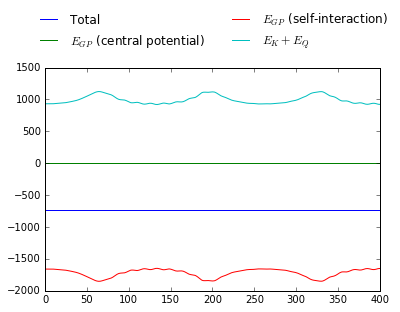

In [7]:
output_animated = 2# 0 for all contours plotted on a single graph, 1 for an animation in time, 2 for energy over time, 3 for line along axis of symmetry 
save_plots = 0 # 0 to just display contours without saving, 1 to save as well. 



if output_animated == 2:

    egylist = np.load('TestOutput/egylist.npy').tolist()
    egpcmlist = np.load('TestOutput/egpcmlist.npy').tolist()
    egpsilist = np.load('TestOutput/egpsilist.npy').tolist()
    ekandqlist = np.load('TestOutput/ekandqlist.npy').tolist()
    masslist = np.load('TestOutput/masslist.npy').tolist()
    plt.plot(egylist,label='Total')
    plt.plot(egpcmlist,label='$E_{GP}$ (central potential)')
    plt.plot(egpsilist,label='$E_{GP}$ (self-interaction)')
    plt.plot(ekandqlist,label='$E_{K}+E_{Q}$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), frameon=False, ncol=2)
    if save_plots == 1:
        plt.savefig('./Visualisations/energy_diagram.eps', format='eps', dpi=1000)
    plt.show()

if output_animated == 0:
    for x in np.arange(0,save_number+1,1):
        if x == 0:
            plt.contour(np.load('{}{}{}{}{}{}{}'.format('TestOutput/plane_r=',r,'_m=',m,'_#',x,'.npy')),colors='k')
        if x in np.arange(1,save_number+1,1):
            plt.contour(np.load('{}{}{}{}{}{}{}'.format('TestOutput/plane_r=',r,'_m=',m,'_#',x,'.npy')))
    if save_plots == 1:
        plt.savefig('{}{}{}{}{}'.format('./Visualisations/r=', r, '_m=', m, '.eps'), format='eps', dpi=1000)


if output_animated == 1:        

    data = []
    for x in np.arange(0,save_number+1,1):
        data.append(np.load('{}{}{}{}{}{}{}'.format('TestOutput/plane_r=',r,'_m=',m,'_#',x,'.npy')))

    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()
    fig,ax = plt.subplots(figsize=(20, 10))
    
    def animate(i):
        plt.clf()
        plot = plt.contourf(data[i])
        plt.axes().set_aspect('equal')
        plt.axes().get_xaxis().set_ticks([])
        plt.axes().get_yaxis().set_ticks([])
        plt.title('{}{}{}{}{}{}'.format('Duration: ', duration, ', Length: ', length, ', Soliton mass: ',m))
        
        
    interval = 0.15 #in seconds
    ani = matplotlib.animation.FuncAnimation(fig,animate,save_number+1,interval=interval*1e+3,blit=False)
    

    from IPython.display import HTML
    animated_plot = HTML(ani.to_jshtml())

    if save_plots == 1:  
        save_html = animated_plot.data
        with open('./Visualisations/plane_animation.html', 'w') as f:
            f.write(save_html)

    display(animated_plot) 
    plt.close()    

        
if output_animated == 3:        

    data = []
    for x in np.arange(0,save_number+1,1):
        data.append(np.load('{}{}{}{}{}{}{}'.format('TestOutput/line_r=',r,'_m=',m,'_#',x,'.npy')))

    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()
    fig,ax = plt.subplots()
    plt.axes().set_aspect('equal')
    
    def animate(i):
        plt.clf()
        plot = plt.plot(data[i])
        
        
    interval = 0.15 #in seconds
    ani2 = matplotlib.animation.FuncAnimation(fig,animate,save_number+1,interval=interval*1e+3,blit=False)
    

    from IPython.display import HTML
    animated_plot2 = HTML(ani2.to_jshtml())

    if save_plots == 1:  
        save_html = animated_plot2.data
        with open('./Visualisations/line_animation.html', 'w') as f:
            f.write(save_html)

    display(animated_plot2) 
    plt.close()    
  